# Deep Fake And Real Image Detection

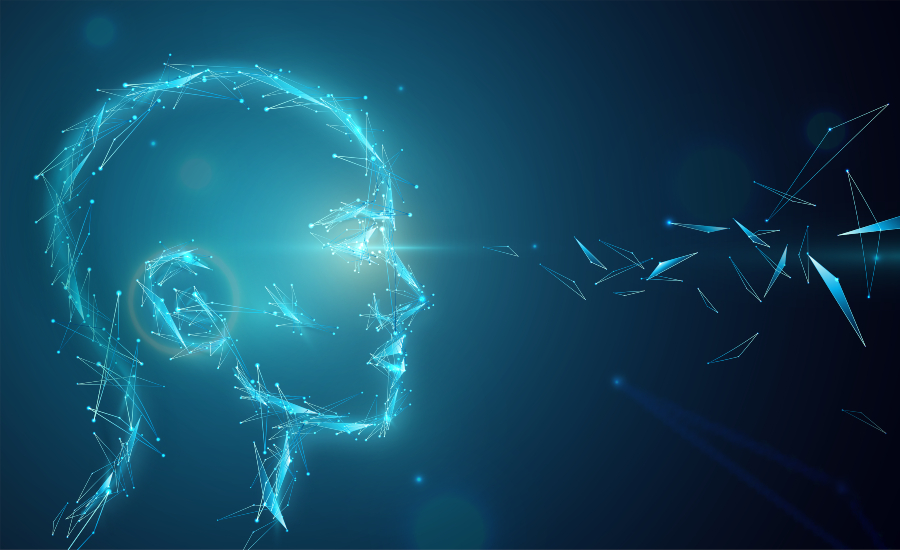

### Gerekli kütüphaneleri yükleme

In [40]:
import numpy as np 
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import concatenate, Input
import cv2
import os


### Veri yükleme işlemleri

In [41]:
data_with_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.3
)

train_generator = data_with_aug.flow_from_directory(
    "RealAndFakeFaces",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = data_with_aug.flow_from_directory(
    "RealAndFakeFaces",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 1429 images belonging to 2 classes.
Found 612 images belonging to 2 classes.


### Örnek gerçek ve sahte resimler

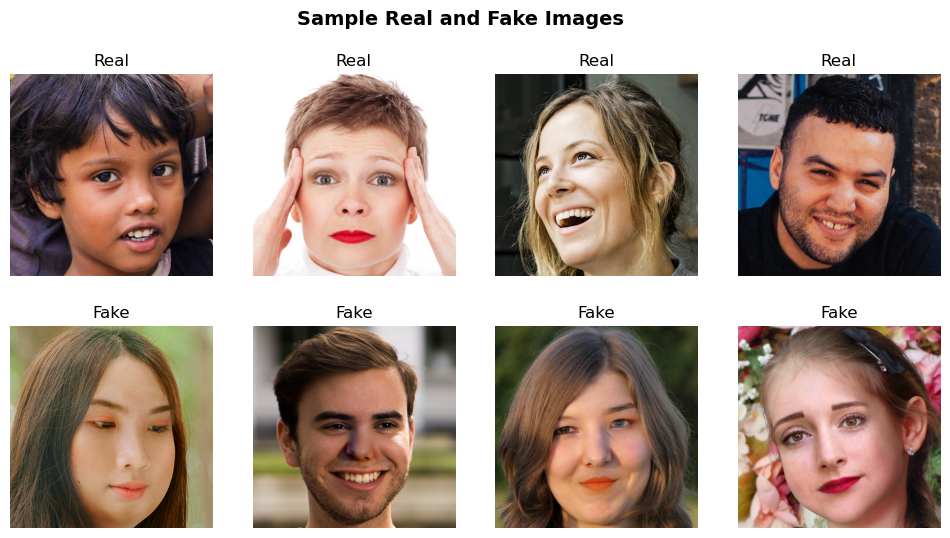

In [78]:
real_dir = os.path.join(data_dir, "real")
fake_dir = os.path.join(data_dir, "fake")

real_images = [cv2.imread(os.path.join(real_dir, img)) for img in os.listdir(real_dir)[:4]]
fake_images = [cv2.imread(os.path.join(fake_dir, img)) for img in os.listdir(fake_dir)[:4]]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Sample Real and Fake Images", fontsize=14, fontweight='bold')

for i, ax in enumerate(axes[0]):
    ax.imshow(cv2.cvtColor(real_images[i], cv2.COLOR_BGR2RGB))
    ax.set_title("Real")
    ax.axis("off")
for i, ax in enumerate(axes[1]):
    ax.imshow(cv2.cvtColor(fake_images[i], cv2.COLOR_BGR2RGB))
    ax.set_title("Fake")
    ax.axis("off")

plt.show()

### Model oluşturma: EfficientNetB0 tabanlı model

In [42]:
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model1 = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(512, activation="relu"),  # Katman sayısını artırma
    Dropout(0.5),  # Dropout katmanı ekleme
    Dense(256, activation="relu"),
    Dropout(0.5),  # Dropout katmanı ekleme
    Dense(1, activation="sigmoid")
])

### İkinci model oluşturma: Özelleştirilmiş Convolutional Neural Network (CNN)

In [43]:
model2 = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

### İki modeli birleştirme

In [44]:
combined_input = Input(shape=(224, 224, 3))
output1 = model1(combined_input)
output2 = model2(combined_input)
merged = concatenate([output1, output2])
output = Dense(1, activation='sigmoid')(merged)
combined_model = tf.keras.Model(inputs=combined_input, outputs=output)

### Model eğitimi

In [45]:
adam_optimizer = Adam(learning_rate=0.0001)  # Optimizasyon parametrelerini ayarlama
combined_model.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

# Eğitim için EarlyStopping callback kullanma
early_stopping = EarlyStopping(patience=10)

history = combined_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
45/45 [==============================] - 197s 4s/step - loss: 0.6759 - accuracy: 0.5766 - val_loss: 0.7733 - val_accuracy: 0.5294
Epoch 2/20
45/45 [==============================] - 175s 4s/step - loss: 0.6448 - accuracy: 0.6417 - val_loss: 0.7653 - val_accuracy: 0.5294
Epoch 3/20
45/45 [==============================] - 176s 4s/step - loss: 0.6348 - accuracy: 0.6564 - val_loss: 0.7548 - val_accuracy: 0.5294
Epoch 4/20
45/45 [==============================] - 178s 4s/step - loss: 0.6275 - accuracy: 0.6690 - val_loss: 0.7647 - val_accuracy: 0.5294
Epoch 5/20
45/45 [==============================] - 169s 4s/step - loss: 0.6085 - accuracy: 0.6977 - val_loss: 0.7623 - val_accuracy: 0.5294
Epoch 6/20
45/45 [==============================] - 175s 4s/step - loss: 0.5984 - accuracy: 0.7054 - val_loss: 0.7592 - val_accuracy: 0.5294
Epoch 7/20
45/45 [==============================] - 175s 4s/step - loss: 0.6018 - accuracy: 0.7166 - val_loss: 0.7288 - val_accuracy: 0.5310
Epoch 8/20
45

### Eğitim sonuçlarını görselleştirme

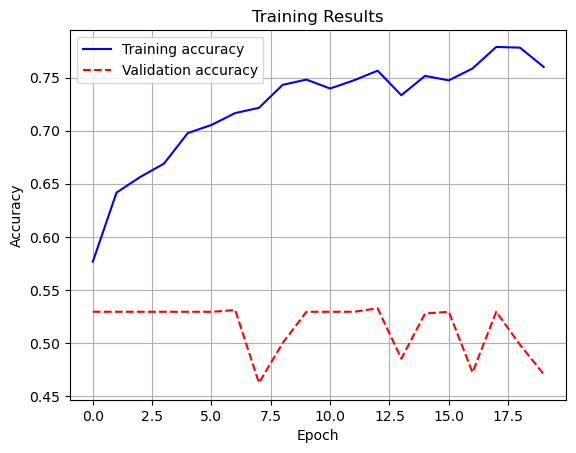

In [46]:
plt.plot(history.history["accuracy"], label="Training accuracy", linestyle="-", color="blue")
plt.plot(history.history["val_accuracy"], label="Validation accuracy", linestyle="--", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Results")
plt.legend()
plt.grid(True)
plt.show()

### Doğruluk yüzdesi

In [47]:
train_accuracy = history.history["accuracy"][-1]
val_accuracy = history.history["val_accuracy"][-1]
accuracy_percentage = max(train_accuracy, val_accuracy) * 100
print("Accuracy Percentage:", "{:.2f}%".format(accuracy_percentage))

Accuracy Percentage: 76.00%


### Veri seti dışından yüz dosyaları okuma ve tahmin etme

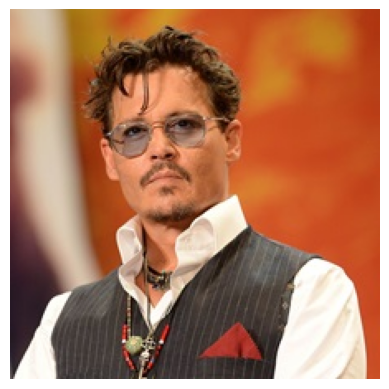

1/1 [==============================] - 0s 114ms/step
Prediction: Real


In [49]:
test_image_path = "image1.jpg"
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  
plt.imshow(test_image)
plt.axis("off")
plt.show()

test_image = cv2.resize(test_image, (224, 224))
test_image = np.expand_dims(test_image, axis=0) / 255.0
prediction = combined_model.predict(test_image)  

if prediction[0][0] < 0.5:
    prediction_text = "Fake"
else:
    prediction_text = "Real"
    
print("Prediction:", prediction_text)

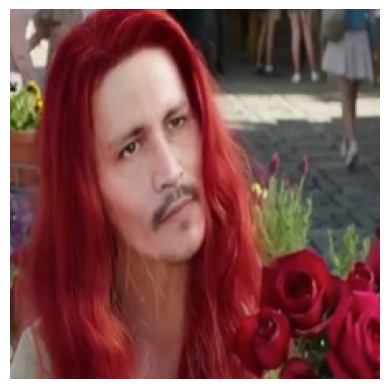

1/1 [==============================] - 0s 91ms/step
Prediction: Fake


In [50]:
test_image_path = "image2.jpg"
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  
plt.imshow(test_image)
plt.axis("off")
plt.show()

test_image = cv2.resize(test_image, (224, 224))
test_image = np.expand_dims(test_image, axis=0) / 255.0
prediction = combined_model.predict(test_image)  

if prediction[0][0] < 0.5:
    prediction_text = "Fake"
else:
    prediction_text = "Real"
    
print("Prediction:", prediction_text)